<a href="https://colab.research.google.com/github/mehrnazeraeisi/Advertising/blob/main/Advertising_KnnRegression_Modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#[1]
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.model_selection import train_test_split


In [2]:

# Function to prioritize features based on KNN R² score
def features_prioritization(X, y, features):
    features_scores = []
    knn_reg = KNeighborsRegressor()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D
        knn_reg.fit(X_feature, y)
        r2 = knn_reg.score(X_feature, y)
        features_scores.append((feature, r2))

    df_scores = pd.DataFrame(features_scores, columns=['Feature', 'R2_Score']).sort_values(by='R2_Score', ascending=False)
    return df_scores


In [4]:
# بارگذاری فایل
data = pd.read_csv('advertising.csv')

print(data.columns)
data.shape

# نمایش اطلاعات
print(data.head())



# جدا کردن ویژگی‌ها و برچسب‌ها
X_data = data.drop('sales', axis=1)  # همه ستون‌ها به جز 'target'
y_data = data['sales']              # فقط ستون 'target'
data_features = X_data.columns       # نام ویژگی‌ها


Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')
      TV  radio  newspaper  sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9


In [23]:
# Run feature prioritization for the iris dataset
data_scores = features_prioritization(X_data, y_data, data_features)
print("🔎 Feature Group Performance Summary (Advertising dataset):")
print(data_scores)  # Categorize features by R² score

🔎 Feature Group Performance Summary (Advertising dataset):
     Feature  R2_Score        MSE
0         TV  0.663212   9.122154
1      radio  0.491364  13.776782
2  newspaper  0.209107  21.421912


In [6]:
# Categorizing features by R² score into multiple levels
strong_features = data_scores[data_scores['R2_Score'] > 0.6]['Feature'].tolist()
medium_features_1 = data_scores[(data_scores['R2_Score'] > 0.4)]['Feature'].tolist()


In [7]:
# Function to safely compute KNN R² score for feature group

def knn_score(X_data, y_data, selected_features):
    if len(selected_features) == 0:  # اصلاح این خط
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    return model.score(X_subset, y_data)

In [8]:
# Function to prioritize features based on KNN MSE

def knn_mse(X_data, y_data, selected_features):
    if len(selected_features) == 0:
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    y_pred = model.predict(X_subset)
    return mean_squared_error(y_data, y_pred)



In [10]:

# Compute R² and accuracy scores for each group
groups = [data_features, strong_features, medium_features_1]

r2_scores = [knn_score(X_data, y_data, group) for group in groups]
mse_scores = [knn_mse(X_data, y_data, group) for group in groups]


In [15]:
# Build summary DataFrame
summary_df = pd.DataFrame({
    'Feature_Group': ['all_Features', 'Strong Features', 'Medium Features_1 (0.7-0.8)'],
    'R2_Score': r2_scores,
    'MSE':mse_scores
})

print("\n📊 Grouped Feature Performance Summary (R² and Accuracy):")
print(summary_df)


📊 Grouped Feature Performance Summary (R² and Accuracy):
                 Feature_Group  R2_Score       MSE
0                 all_Features  0.952944  1.274538
1              Strong Features  0.663212  9.122154
2  Medium Features_1 (0.7-0.8)  0.976655  0.632320


In [16]:

def knn_evaluation(X_data, y_data,medium_features_1, data_features, test_size, n_repeats):
    # Initialize lists to store the results

    mse_scores = {
        "all_features": [],
        "medium_features_1": []
    }



    r2_scores = {
        "all_features": [],
        "medium_features_1": [],

    }


    # List of feature groups to evaluate
    feature_groups = {
        "all_features": data_features,
        "medium_features_1": medium_features_1,

    }

    # Repeat the process n_repeats times with different train-test splits
    for _ in range(n_repeats):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            # KNN Regressor
            knn_reg = KNeighborsRegressor(n_neighbors=5)
            knn_reg.fit(X_train[group_features], y_train)
            y_pred_reg = knn_reg.predict(X_test[group_features])
            r2_scores[group_name].append(r2_score(y_test, y_pred_reg))
            mse_scores[group_name].append(mean_squared_error(y_test, y_pred_reg))

    # Plot results for R² and Accuracy
    x = np.arange(1, n_repeats + 1)


    # R² plot
    plt.figure( figsize=(8, 4))
    for group_name, r2_list in r2_scores.items():
        plt.plot(x, r2_list, label=f"{group_name.replace('_', ' ').title()} R²", marker='x')
    plt.xlabel('Repeat')
    plt.ylabel('R² Score')
    plt.title('KNN Regressor Performance')
    plt.legend()
    plt.show()

    # MSE plot
    plt.figure(figsize=(8, 4))
    for group_name, mse_list in mse_scores.items():
        plt.plot(x, mse_list, label=f"{group_name.replace('_', ' ').title()} MSE", marker='s')
    plt.xlabel('Repeat')
    plt.ylabel('Mean Squared Error')
    plt.title('KNN Regressor MSE Performance')
    plt.legend()
    plt.show()


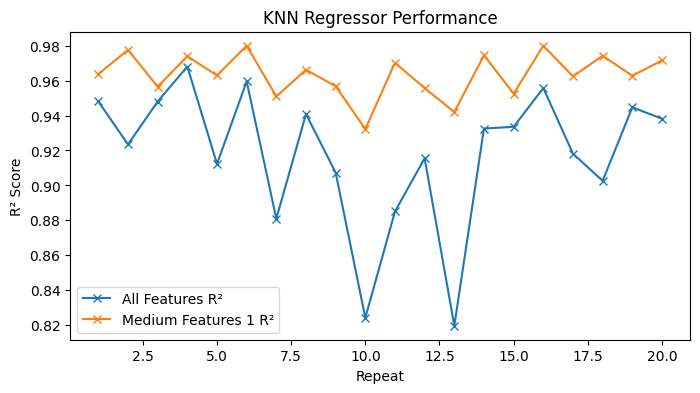

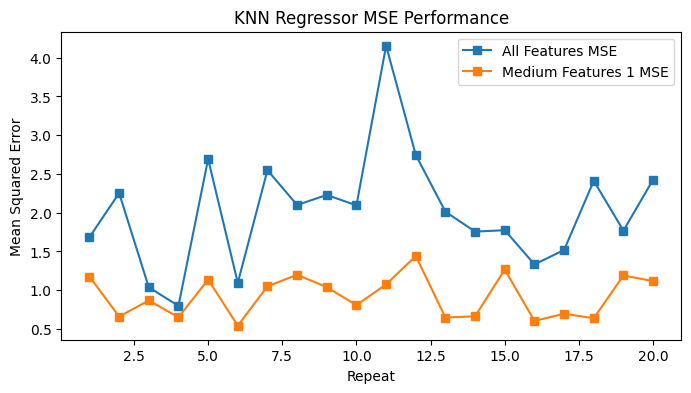

In [17]:

# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, medium_features_1,  data_features, test_size=0.1, n_repeats=20)


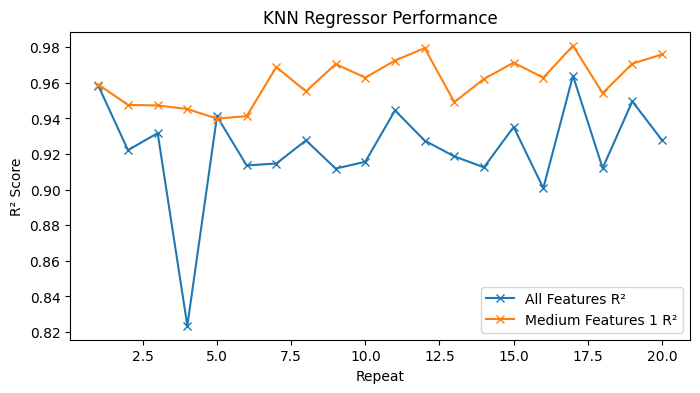

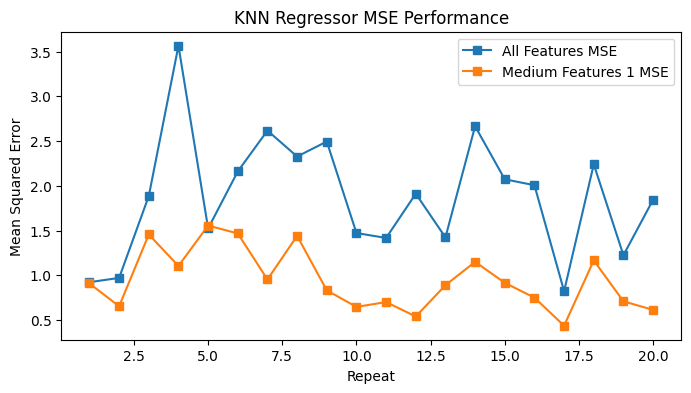

In [18]:
# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, medium_features_1,  data_features, test_size=0.13, n_repeats=20)


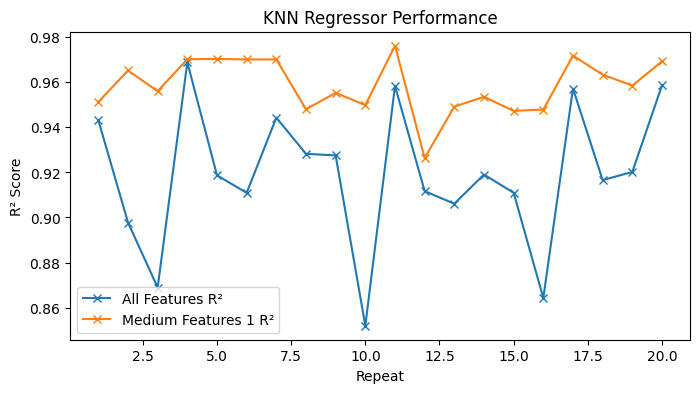

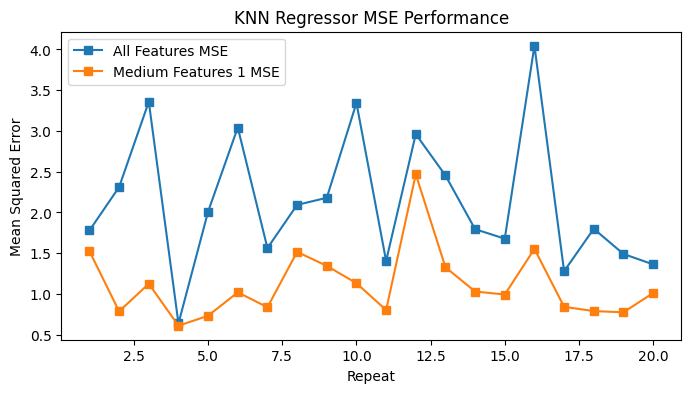

In [19]:
# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, medium_features_1, data_features, test_size=0.16, n_repeats=20)


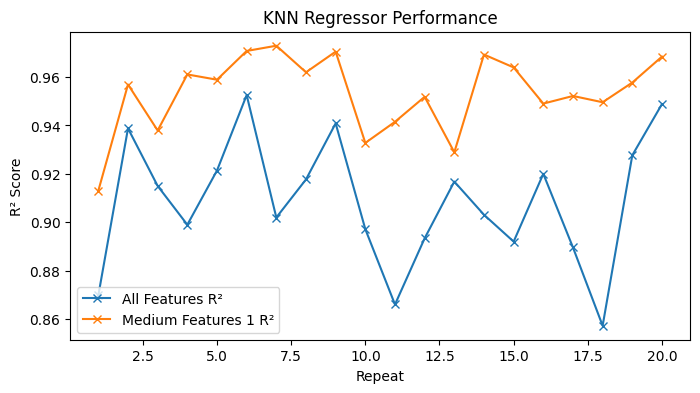

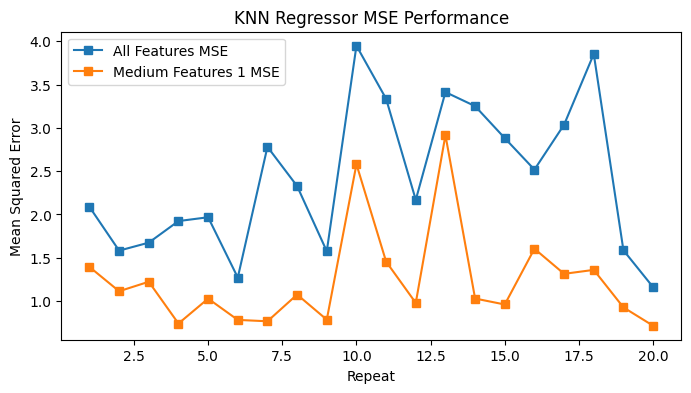

In [20]:
# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, medium_features_1, data_features, test_size=0.19, n_repeats=20)


In [21]:

def knn_evaluation_table(X_data, y_data,  medium_features_1, data_features, test_sizes, n_repeats):
    results = []

    feature_groups = {
        "All": data_features,
        "medium_features_1": medium_features_1
    }

    for test_size in test_sizes:
        for i in range(1, n_repeats + 1):
            X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

            # محاسبه برای همه ویژگی‌ها
            knn_reg_all = KNeighborsRegressor(n_neighbors=5)
            knn_reg_all.fit(X_train[feature_groups["All"]], y_train)
            y_pred_all = knn_reg_all.predict(X_test[feature_groups["All"]])
            mse_all = mean_squared_error(y_test, y_pred_all)
            r2_all = r2_score(y_test, y_pred_all)

            # محاسبه برای ویژگی‌های متوسط
            knn_reg_modified = KNeighborsRegressor(n_neighbors=5)
            knn_reg_modified.fit(X_train[feature_groups["medium_features_1"]], y_train)
            y_pred_modified = knn_reg_modified.predict(X_test[feature_groups["medium_features_1"]])
            mse_modified = mean_squared_error(y_test, y_pred_modified)
            r2_modified = r2_score(y_test, y_pred_modified)

            # ذخیره در لیست
            results.append({
                "Percentage": f"{int(test_size * 100)}%",
                "Repetition": f"n={i}",
                "MSE_All": mse_all,
                "R2_All": r2_all,
                "MSE_Modified": mse_modified,
                "R2_Modified": r2_modified
            })

    # ساخت دیتافریم خروجی
    df_result = pd.DataFrame(results)
    return df_result


# درصدهای تست مختلف
test_sizes = [0.10, 0.13, 0.16, 0.19, 0.25]
n_repeats = 20

# اجرای ارزیابی و دریافت جدول
final_df = knn_evaluation_table(X_data, y_data,  medium_features_1, data_features, test_sizes, n_repeats)

# نمایش جدول
print(final_df)

# (اختیاری) ذخیره جدول در فایل اکسل یا CSV
# final_df.to_csv("knn_results_table.csv", index=False)


   Percentage Repetition   MSE_All    R2_All  MSE_Modified  R2_Modified
0         10%        n=1  1.692800  0.903931      0.889080     0.949543
1         10%        n=2  1.263560  0.928226      0.748780     0.957467
2         10%        n=3  4.048420  0.906266      1.460460     0.966186
3         10%        n=4  1.913040  0.939041      0.912520     0.970923
4         10%        n=5  0.925600  0.957628      0.621500     0.971549
..        ...        ...       ...       ...           ...          ...
95        25%       n=16  2.970000  0.879669      1.143200     0.953683
96        25%       n=17  2.072160  0.927052      1.146040     0.959655
97        25%       n=18  3.864584  0.857749      1.128976     0.958444
98        25%       n=19  1.357408  0.942714      0.676592     0.971446
99        25%       n=20  3.214552  0.862563      1.199912     0.948698

[100 rows x 6 columns]


Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')
      TV  radio  newspaper  sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9
🔎 Feature Group Performance Summary (Advertising dataset):
     Feature  R2_Score        MSE
0         TV  0.663212   9.122154
1      radio  0.491364  13.776782
2  newspaper  0.209107  21.421912

📊 Grouped Feature Performance Summary (R² and Accuracy):
                 Feature_Group  R2_Score       MSE
0                 all_Features  0.952944  1.274538
1              Strong Features  0.663212  9.122154
2  Medium Features_1 (0.7-0.8)  0.976655  0.632320


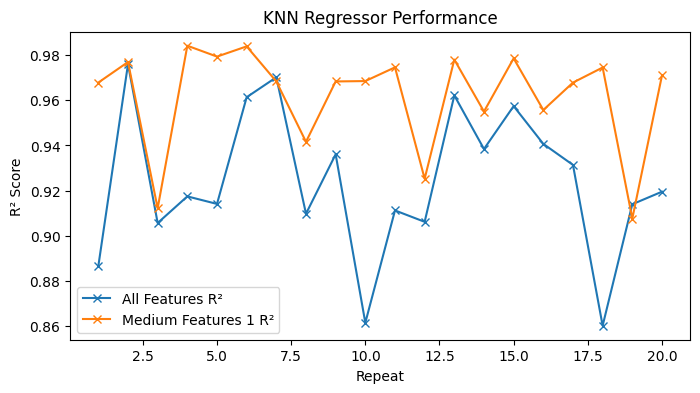

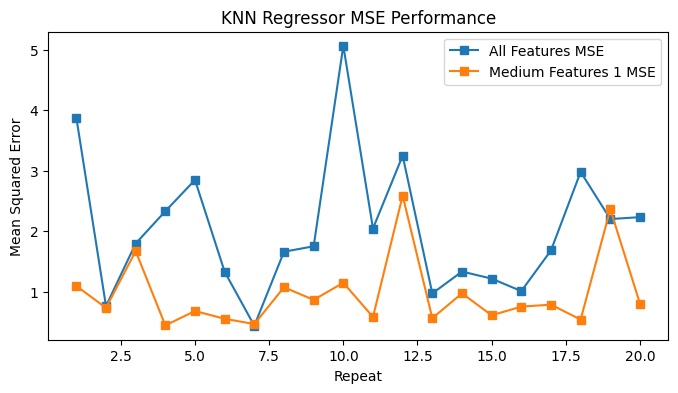

   Percentage Repetition   MSE_All    R2_All  MSE_Modified  R2_Modified
0         10%        n=1  1.405580  0.959003      0.656900     0.980840
1         10%        n=2  1.578380  0.946355      0.646020     0.978043
2         10%        n=3  1.891320  0.907076      1.163440     0.942838
3         10%        n=4  1.023180  0.965038      0.421500     0.985597
4         10%        n=5  2.721560  0.923086      1.170800     0.966912
..        ...        ...       ...       ...           ...          ...
95        25%       n=16  2.171880  0.936323      1.683616     0.950638
96        25%       n=17  2.442832  0.908057      1.519096     0.942824
97        25%       n=18  4.871352  0.731777      2.792904     0.846219
98        25%       n=19  2.732864  0.877131      1.251984     0.943711
99        25%       n=20  1.654320  0.920632      1.250752     0.939994

[100 rows x 6 columns]


In [24]:
#[1]
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.model_selection import train_test_split


# Function to prioritize features based on KNN R² score
def features_prioritization(X, y, features):
    features_scores = []
    knn_reg = KNeighborsRegressor()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D
        knn_reg.fit(X_feature, y)
        y_pred = knn_reg.predict(X_feature)
        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        features_scores.append((feature, r2, mse))  # اضافه شد

    df_scores = pd.DataFrame(features_scores, columns=['Feature', 'R2_Score', 'MSE']).sort_values(by='R2_Score', ascending=False)
    return df_scores

# بارگذاری فایل
data = pd.read_csv('advertising.csv')

print(data.columns)
data.shape

# نمایش اطلاعات
print(data.head())



# جدا کردن ویژگی‌ها و برچسب‌ها
X_data = data.drop('sales', axis=1)  # همه ستون‌ها به جز 'target'
y_data = data['sales']              # فقط ستون 'target'
data_features = X_data.columns       # نام ویژگی‌ها

#[5]
# Run feature prioritization for the iris dataset
data_scores = features_prioritization(X_data, y_data, data_features)
print("🔎 Feature Group Performance Summary (Advertising dataset):")
print(data_scores)  # Categorize features by R² score

# Categorizing features by R² score into multiple levels
strong_features = data_scores[data_scores['R2_Score'] > 0.6]['Feature'].tolist()
medium_features_1 = data_scores[(data_scores['R2_Score'] > 0.4)]['Feature'].tolist()


#[7]
# Function to safely compute KNN R² score for feature group

def knn_score(X_data, y_data, selected_features):
    if len(selected_features) == 0:  # اصلاح این خط
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    return model.score(X_subset, y_data)


# Function to prioritize features based on KNN MSE

def knn_mse(X_data, y_data, selected_features):
    if len(selected_features) == 0:
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    y_pred = model.predict(X_subset)
    return mean_squared_error(y_data, y_pred)





# Compute R² and accuracy scores for each group
groups = [data_features, strong_features, medium_features_1]

r2_scores = [knn_score(X_data, y_data, group) for group in groups]
mse_scores = [knn_mse(X_data, y_data, group) for group in groups]

# Build summary DataFrame
summary_df = pd.DataFrame({
    'Feature_Group': ['all_Features', 'Strong Features', 'Medium Features_1 (0.7-0.8)'],
    'R2_Score': r2_scores,
    'MSE':mse_scores

})

print("\n📊 Grouped Feature Performance Summary (R² and Accuracy):")
print(summary_df)



def knn_evaluation(X_data, y_data, medium_features_1, data_features, test_size, n_repeats):
    # Initialize lists to store the results

    mse_scores = {
        "all_features": [],
        "medium_features_1": []
    }


    r2_scores = {
        "all_features": [],
        "medium_features_1": [],
    }

    # List of feature groups to evaluate
    feature_groups = {
        "all_features": data_features,
        "medium_features_1": medium_features_1,
    }

    # Repeat the process n_repeats times with different train-test splits
    for _ in range(n_repeats):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            # KNN Regressor
            knn_reg = KNeighborsRegressor(n_neighbors=5)
            knn_reg.fit(X_train[group_features], y_train)
            y_pred_reg = knn_reg.predict(X_test[group_features])
            r2_scores[group_name].append(r2_score(y_test, y_pred_reg))
            mse_scores[group_name].append(mean_squared_error(y_test, y_pred_reg))

    # Plot results for R² and Accuracy
    x = np.arange(1, n_repeats + 1)


    # R² plot
    plt.figure( figsize=(8, 4))
    for group_name, r2_list in r2_scores.items():
        plt.plot(x, r2_list, label=f"{group_name.replace('_', ' ').title()} R²", marker='x')
    plt.xlabel('Repeat')
    plt.ylabel('R² Score')
    plt.title('KNN Regressor Performance')
    plt.legend()
    plt.show()

    # MSE plot
    plt.figure(figsize=(8, 4))
    for group_name, mse_list in mse_scores.items():
        plt.plot(x, mse_list, label=f"{group_name.replace('_', ' ').title()} MSE", marker='s')
    plt.xlabel('Repeat')
    plt.ylabel('Mean Squared Error')
    plt.title('KNN Regressor MSE Performance')
    plt.legend()
    plt.show()


# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data,  medium_features_1, data_features, test_size=0.10, n_repeats=20)



def knn_evaluation_table(X_data, y_data,  medium_features_1, data_features, test_sizes, n_repeats):
    results = []

    feature_groups = {
        "All": data_features,
        "medium_features_1": medium_features_1
    }

    for test_size in test_sizes:
        for i in range(1, n_repeats + 1):
            X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

            # محاسبه برای همه ویژگی‌ها
            knn_reg_all = KNeighborsRegressor(n_neighbors=5)
            knn_reg_all.fit(X_train[feature_groups["All"]], y_train)
            y_pred_all = knn_reg_all.predict(X_test[feature_groups["All"]])
            mse_all = mean_squared_error(y_test, y_pred_all)
            r2_all = r2_score(y_test, y_pred_all)

            # محاسبه برای ویژگی‌های متوسط
            knn_reg_modified = KNeighborsRegressor(n_neighbors=5)
            knn_reg_modified.fit(X_train[feature_groups["medium_features_1"]], y_train)
            y_pred_modified = knn_reg_modified.predict(X_test[feature_groups["medium_features_1"]])
            mse_modified = mean_squared_error(y_test, y_pred_modified)
            r2_modified = r2_score(y_test, y_pred_modified)

            # ذخیره در لیست
            results.append({
                "Percentage": f"{int(test_size * 100)}%",
                "Repetition": f"n={i}",
                "MSE_All": mse_all,
                "R2_All": r2_all,
                "MSE_Modified": mse_modified,
                "R2_Modified": r2_modified
            })

    # ساخت دیتافریم خروجی
    df_result = pd.DataFrame(results)
    return df_result


# درصدهای تست مختلف
test_sizes = [0.10, 0.13, 0.16, 0.19, 0.25]
n_repeats = 20

# اجرای ارزیابی و دریافت جدول
final_df = knn_evaluation_table(X_data, y_data,  medium_features_1, data_features, test_sizes, n_repeats)

# نمایش جدول
print(final_df)

# (اختیاری) ذخیره جدول در فایل اکسل یا CSV
# final_df.to_csv("knn_results_table.csv", index=False)
